# V. MORO - Directed search

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
import time
import json

from specify import (specify_levers, specify_scenario, default_scenario)
from problem_formulation import get_model_for_problem_formulation

from ema_workbench import (Model, MultiprocessingEvaluator, Policy, Scenario, ScalarOutcome)
from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.util import ema_logging

from ema_workbench.em_framework.evaluators import BaseEvaluator
from ema_workbench.em_framework.optimization import EpsilonProgress, HyperVolume
from ema_workbench.analysis import parcoords
from ema_workbench import save_results
from ema_workbench import load_results

ema_logging.log_to_stderr(ema_logging.INFO)
BaseEvaluator.reporting_frequency = 0.1
# ema_logging.log_to_stderr(ema_logging.DEBUG)

C:\Users\Shajee\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Users\Shajee\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Users\Shajee\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


## 0. Define the problem

In [2]:
dike_model = get_model_for_problem_formulation(4)
policy = Policy('policy', **specify_levers(0,0,0,0,0,0,0,0,0,0,0)) # DO NOTHING
#policy1 = Policy('policy_1', **specify_levers(10,10,10,10,10,1,1,1,1,1,4)) # DO EVERYTHING
dike_model.outcomes.keys()

[MainProcess/INFO] model initialized


odict_keys(['Expected Number of Deaths', 'RfR Total Costs', 'Expected Evacuation Costs', 'Gelderland Dike Investment Costs', 'OverIjsel Dike Investment Costs', 'GelderlandUpstream Expected Annual Damage', 'GelderlandDownstream Expected Annual Damage', 'OverIjsel Expected Annual Damage'])

## 1. Upload Open Exploration for 4 policies

In [3]:
results = load_results('open_exploration_10k_4pol_8obj.tar.gz')

[MainProcess/INFO] results loaded succesfully from C:\Users\Shajee\Desktop\mbdm1\MBDM\open_exploration_10k_4pol_8obj.tar.gz


In [4]:
experiments, outcomes = results

In [5]:
OUT_DF = pd.DataFrame(outcomes)

In [6]:
OUT_DF

,Expected Evacuation Costs,Expected Number of Deaths,Gelderland Dike Investment Costs,GelderlandDownstream Expected Annual Damage,GelderlandUpstream Expected Annual Damage,OverIjsel Dike Investment Costs,OverIjsel Expected Annual Damage,RfR Total Costs
0,0.000000,0.915728,0.000000e+00,4.194014e+08,3.660176e+08,0.000000e+00,1.316510e+08,0.0
1,0.000000,1.545620,0.000000e+00,3.229789e+08,8.548425e+08,0.000000e+00,2.656806e+07,0.0
2,0.000000,0.824081,0.000000e+00,1.074126e+08,1.140816e+09,0.000000e+00,3.962410e+07,0.0
3,0.000000,0.140737,0.000000e+00,6.745645e+07,2.726361e+07,0.000000e+00,2.800264e+07,0.0
4,0.000000,2.191504,0.000000e+00,7.920455e+08,1.393419e+09,0.000000e+00,1.905886e+08,0.0
5,0.000000,1.288987,0.000000e+00,7.949327e+08,8.530199e+07,0.000000e+00,6.146235e+07,0.0
6,0.000000,0.369796,0.000000e+00,2.901087e+07,2.383994e+08,0.000000e+00,1.831900e+07,0.0
7,0.000000,0.335491,0.000000e+00,4.085055e+07,3.270646e+07,0.000000e+00,1.596773e+08,0.0
8,0.000000,0.322578,0.000000e+00,6.240546e+07,8.928908e+06,0.000000e+00,2.753439e+08,0.0
9,0.000000,1.354102,0.000000e+00,5.003538e+08,1.805211e+08,0.000000e+00,2.637822e+07,0.0


## 2. Run MORDM

### 2.1 Upload worst cases

We want to find what is the worst case scenario if we won't do anything.

In [12]:
# # Load results

with open('MORDM_worst_case_10Knfe') as data_file:
      worst_case_scenario = json.loads(data_file.read())

w0 = specify_scenario(reference_values=worst_case_scenario[0], dike_model=dike_model)
        
# convergence = pd.read_excel('MORDM_convergence_10Knfe.xlsx')
# results = pd.read_excel('MORDM_results_10Knfe.xlsx')

### 2.2 Identify policies

We want to find policies that will perform 'good' under the worst case scenario.

In [13]:
n_scenarios = 40000
# Epsilon dominance
epsilons = OUT_DF.iloc[:int(n_scenarios),:].max().values

# Empirically found denominator for defyining epsilon dominance 
denominator = 1e4
epsilons = epsilons / denominator
epsilons

array([2.31893260e-01, 2.49358037e-04, 1.85253239e+04, 8.70364921e+04,
       1.50512861e+05, 4.15743624e+03, 5.12268214e+04, 7.10400000e+04])

In [14]:
from ema_workbench import Constraint

nfe = 1000

epsilons = epsilons

#Take max and min values from run with zero policy and full policy in section 1

convergence_metrics = [EpsilonProgress()]

constraint = [Constraint('Expected Number of Deaths', outcome_names = 'Expected Number of Deaths', function=lambda x:max(0,x-(0.01*(OUT_DF['Expected Number of Deaths'].max()))))]

for outcome in dike_model.outcomes:
    if outcome.kind == maximize:
        outcome.kind = minimize
    else:
        outcome.kind = maximize

start = time.time()
with MultiprocessingEvaluator(dike_model) as evaluator:
    results, convergence = evaluator.optimize(nfe=nfe,
                                              searchover='levers',
                                              epsilons=epsilons,
                                              convergence=convergence_metrics,
                                              reference=w0,
                                              constraints = constraint)
end = time.time()
print('Optimization time is ' + str(round((end - start)/60)) + ' mintues')

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/1000 nfe
[MainProcess/INFO] performing 1 scenarios * 100 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 1: 100/1000 nfe
[MainProcess/INFO] performing 1 scenarios * 99 policies * 1 model(s) = 99 experiments
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 2: 199/1000 nfe
[MainProcess/INFO] performing 1 scenarios * 100 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 3: 299/1000 nfe
[MainProcess/INFO] performing 1 scenarios * 99 policies * 1 model(s) = 99 experiments
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 4: 398/1000 nfe
[MainProcess/INFO] performing 1 scenarios * 100 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 5: 498/1000 nfe
[MainProcess/INFO] performing 1 scenarios * 100 policies *

Optimization time is 6 mintues


In [15]:
print('Found ' + str(len(results)) + ' solutions' + '\n')

Found 217 solutions



In [16]:
results["Total Investment Cost"] = results[["RfR Total Costs", "Gelderland Dike Investment Costs", "OverIjsel Dike Investment Costs"]].sum(axis=1) 

In [17]:
results

,A.1_DikeIncrease,A.2_DikeIncrease,A.3_DikeIncrease,A.4_DikeIncrease,A.5_DikeIncrease,0_RfR,1_RfR,2_RfR,3_RfR,4_RfR,EWS_DaysToThreat,Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs,Gelderland Dike Investment Costs,OverIjsel Dike Investment Costs,GelderlandUpstream Expected Annual Damage,GelderlandDownstream Expected Annual Damage,OverIjsel Expected Annual Damage,Total Investment Cost
0,9,8,3,9,9,1,0,1,0,0,4,0.016343,115300000.0,5202.437131,1.604210e+08,3.925350e+07,0.000000e+00,7.145428e+07,2.805538e+07,3.149745e+08
1,0,2,8,2,6,1,1,1,1,1,2,0.018304,710400000.0,7237.445739,7.538793e+07,3.292058e+07,8.450887e+07,2.958657e+07,5.194392e+07,8.187085e+08
2,4,6,3,1,4,1,0,1,1,0,4,0.024779,236500000.0,15478.664804,1.238070e+08,2.917962e+07,6.078946e+06,9.368396e+07,1.362089e+08,3.894867e+08
3,2,6,5,2,9,0,0,0,0,1,3,0.020814,256100000.0,7366.337816,1.200210e+08,3.925350e+07,8.785918e+07,8.572009e+07,2.805538e+07,4.153745e+08
4,10,10,8,8,7,1,1,0,1,1,2,0.007054,679700000.0,2436.084010,1.798978e+08,3.493112e+07,0.000000e+00,2.725078e+06,5.194392e+07,8.945290e+08
5,1,7,4,4,10,1,1,1,0,1,4,0.011963,589200000.0,4929.573210,1.211229e+08,4.157436e+07,1.398647e+06,6.695828e+07,1.784044e+07,7.518973e+08
6,7,5,6,4,6,1,0,0,0,1,3,0.024334,340700000.0,10999.010634,1.382225e+08,3.292058e+07,2.457572e+07,6.782316e+07,1.172919e+08,5.118431e+08
7,5,7,7,0,7,1,1,0,1,1,3,0.009853,679700000.0,6894.164428,1.306245e+08,3.493112e+07,2.780726e+06,6.030278e+07,5.194392e+07,8.452556e+08
8,0,10,4,2,7,1,1,1,0,0,4,0.017666,333100000.0,9966.728429,1.010616e+08,3.493112e+07,2.815354e+06,9.539398e+07,6.118836e+07,4.690927e+08
9,8,1,7,4,9,0,0,1,0,0,3,0.020730,30700000.0,11731.175377,1.308216e+08,3.925350e+07,1.723262e+08,2.467423e+07,2.805538e+07,2.007751e+08


In [18]:
res = results[(results["Total Investment Cost"]<335000000) & (results["Expected Number of Deaths"]<0.01)]

In [19]:
res

,A.1_DikeIncrease,A.2_DikeIncrease,A.3_DikeIncrease,A.4_DikeIncrease,A.5_DikeIncrease,0_RfR,1_RfR,2_RfR,3_RfR,4_RfR,EWS_DaysToThreat,Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs,Gelderland Dike Investment Costs,OverIjsel Dike Investment Costs,GelderlandUpstream Expected Annual Damage,GelderlandDownstream Expected Annual Damage,OverIjsel Expected Annual Damage,Total Investment Cost
33,2,10,9,4,8,1,0,0,0,0,3,0.007250,84600000.0,4824.454259,1.444448e+08,3.704062e+07,0.000000e+00,2.204714e+07,6.118836e+07,2.660854e+08
77,7,8,7,4,10,1,0,1,0,0,3,0.003478,115300000.0,2501.548476,1.515030e+08,4.157436e+07,0.000000e+00,2.467423e+07,1.784044e+07,3.083774e+08
129,8,3,8,2,10,0,0,0,1,0,4,0.008486,121200000.0,6610.407902,1.369227e+08,4.157436e+07,5.746143e+07,4.041006e+07,3.989651e+06,2.996971e+08
190,7,7,7,2,7,1,0,1,0,0,4,0.009157,115300000.0,7983.999777,1.457121e+08,3.493112e+07,1.398647e+06,5.152224e+07,6.118836e+07,2.959432e+08


In [20]:
res.describe()

,A.1_DikeIncrease,A.2_DikeIncrease,A.3_DikeIncrease,A.4_DikeIncrease,A.5_DikeIncrease,0_RfR,1_RfR,2_RfR,3_RfR,4_RfR,EWS_DaysToThreat,Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs,Gelderland Dike Investment Costs,OverIjsel Dike Investment Costs,GelderlandUpstream Expected Annual Damage,GelderlandDownstream Expected Annual Damage,OverIjsel Expected Annual Damage,Total Investment Cost
count,4.000000,4.00000,4.000000,4.000000,4.00,4.00,4.0,4.00000,4.00,4.0,4.00000,4.000000,4.000000e+00,4.000000,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00
mean,6.000000,7.00000,7.750000,3.000000,8.75,0.75,0.0,0.50000,0.25,0.0,3.50000,0.007093,1.091000e+08,5480.102603,1.446457e+08,3.878011e+07,1.471502e+07,3.466342e+07,3.605170e+07,2.925258e+08
std,2.708013,2.94392,0.957427,1.154701,1.50,0.50,0.0,0.57735,0.50,0.0,0.57735,0.002536,1.656844e+07,2369.862905,5.995700e+06,3.339475e+06,2.850524e+07,1.385879e+07,2.957098e+07,1.837999e+07
min,2.000000,3.00000,7.000000,2.000000,7.00,0.00,0.0,0.00000,0.00,0.0,3.00000,0.003478,8.460000e+07,2501.548476,1.369227e+08,3.493112e+07,0.000000e+00,2.204714e+07,3.989651e+06,2.660854e+08
25%,5.750000,6.00000,7.000000,2.000000,7.75,0.75,0.0,0.00000,0.00,0.0,3.00000,0.006307,1.076250e+08,4243.727813,1.425643e+08,3.651324e+07,0.000000e+00,2.401746e+07,1.437774e+07,2.884788e+08
50%,7.000000,7.50000,7.500000,3.000000,9.00,1.00,0.0,0.50000,0.00,0.0,3.50000,0.007868,1.153000e+08,5717.431080,1.450785e+08,3.930749e+07,6.993236e+05,3.254215e+07,3.951440e+07,2.978202e+08
75%,7.250000,8.50000,8.250000,4.000000,10.00,1.00,0.0,1.00000,0.25,0.0,4.00000,0.008654,1.167750e+08,6953.805871,1.471598e+08,4.157436e+07,1.541434e+07,4.318811e+07,6.118836e+07,3.018672e+08
max,8.000000,10.00000,9.000000,4.000000,10.00,1.00,0.0,1.00000,1.00,0.0,4.00000,0.009157,1.212000e+08,7983.999777,1.515030e+08,4.157436e+07,5.746143e+07,5.152224e+07,6.118836e+07,3.083774e+08


In [21]:
print('MEDIAN of Expected Evacuation Costs = ' + str(round(res['Expected Evacuation Costs'].median())) + '\n' + 
      'MEDIAN of RfR Total Costs = ' + str(round(res['RfR Total Costs'].median())) + '\n' + 
      'MEDIAN of Expected Number of Deaths = ' + str(res['Expected Number of Deaths'].median()) + '\n' +
      'MEDIAN of Gelderland Dike Investment Costs = ' + str(res['Gelderland Dike Investment Costs'].median()) + '\n' +
      'MEDIAN of OverIjsel Dike Investment Costs = ' + str(round(res['OverIjsel Dike Investment Costs'].median())) + '\n' + 
      'MEDIAN of GelderlandUpstream Expected Annual Damage = ' + str(res['GelderlandUpstream Expected Annual Damage'].median()) + '\n' +
      'MEDIAN of GelderlandDownstream Expected Annual Damage = ' + str(res['GelderlandDownstream Expected Annual Damage'].median()) + '\n' +
      'MEDIAN of OverIjsel Expected Annual Damage = ' + str(round(res['OverIjsel Expected Annual Damage'].median())) + '\n')

MEDIAN of Expected Evacuation Costs = 5717
MEDIAN of RfR Total Costs = 115300000
MEDIAN of Expected Number of Deaths = 0.007867915397509705
MEDIAN of Gelderland Dike Investment Costs = 145078463.1875669
MEDIAN of OverIjsel Dike Investment Costs = 39307490
MEDIAN of GelderlandUpstream Expected Annual Damage = 699323.6452336891
MEDIAN of GelderlandDownstream Expected Annual Damage = 32542148.48140558
MEDIAN of OverIjsel Expected Annual Damage = 39514398



#### Check convergence

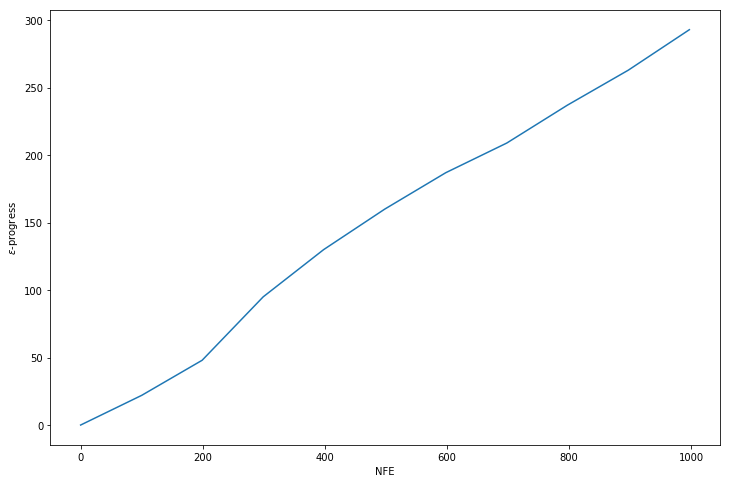

In [22]:
fig, ax1 = plt.subplots(figsize=(12,8))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax1.set_xlabel('NFE')
plt.show()

## 3. MORO

In [23]:
# Basic packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import time
import functools

# Basic EMA Workbench packages
from ema_workbench import (Model, MultiprocessingEvaluator, Policy, Scenario, ScalarOutcome)
from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.util import ema_logging

# Optimization EMA Workbench packages
from ema_workbench.em_framework.evaluators import BaseEvaluator
from ema_workbench.em_framework.optimization import EpsilonProgress, HyperVolume
from ema_workbench.analysis import parcoords

ema_logging.log_to_stderr(ema_logging.INFO)
BaseEvaluator.reporting_frequency = 0.1

### 3.1 Define Robustness

In [36]:
def robustness(direction, threshold, data):
    if direction == SMALLER:
        return np.sum(data<=threshold)/data.shape[0]
    else:
        return np.sum(data>=threshold)/data.shape[0]
    
def costs(data):
    return data[0]/1e9

def cost(data):
    return data[0]/1e4

SMALLER = 'SMALLER'
LARGER = 'LARGER'

expected_number_of_deaths = functools.partial(robustness, SMALLER, res['Expected Number of Deaths'].median())
gel_downstream_expected_annual_damage = functools.partial(robustness, SMALLER, res['GelderlandDownstream Expected Annual Damage'].median())
gel_upstream_expected_annual_damage = functools.partial(robustness, SMALLER, res['GelderlandUpstream Expected Annual Damage'].median())
ijs_expected_annual_damage = functools.partial(robustness, SMALLER, res['OverIjsel Expected Annual Damage'].median())
evacuation_costs = cost
gel_dike_investment_costs = costs
ijs_dike_investment_costs = costs
rfr_total_investment_costs = costs

### 3.2 Define Robustness Functions

In [37]:
MAXIMIZE = ScalarOutcome.MAXIMIZE
MINIMIZE = ScalarOutcome.MINIMIZE
INFO = ScalarOutcome.INFO


robustness_funcs = {'Expected Number of Deaths': expected_number_of_deaths,
                    'GelderlandDownstream Expected Annual Damage': gel_downstream_expected_annual_damage,
                    'GelderlandUpstream Expected Annual Damage': gel_upstream_expected_annual_damage,
                    'OverIjsel Expected Annual Damage': ijs_expected_annual_damage,
                    'Expected Evacuation Costs': evacuation_costs,                 
                    'Gelderland Dike Investment Costs': gel_dike_investment_costs,
                    'OverIjsel Dike Investment Costs': ijs_dike_investment_costs, 
                    'RfR Total Costs': rfr_total_investment_costs}


robustness_functions = [ScalarOutcome('Expected Number of Deaths', kind=MAXIMIZE, 
                             variable_name='Expected Number of Deaths', function=expected_number_of_deaths),
                        ScalarOutcome('GelderlandDownstream Expected Annual Damage', kind=MAXIMIZE, 
                             variable_name='GelderlandDownstream Expected Annual Damage', function=gel_downstream_expected_annual_damage),
                        ScalarOutcome('GelderlandUpstream Expected Annual Damage', kind=MAXIMIZE, 
                             variable_name='GelderlandUpstream Expected Annual Damage', function=gel_upstream_expected_annual_damage),
                        ScalarOutcome('OverIjsel Expected Annual Damage', kind=MAXIMIZE, 
                             variable_name='OverIjsel Expected Annual Damage', function=ijs_expected_annual_damage),
                        ScalarOutcome('Gelderland Dike Investment Costs', kind=MINIMIZE,
                             variable_name='Gelderland Dike Investment Costs', function=gel_dike_investment_costs)]

### 3.3 Optimal Policies

In [ ]:
# scenarios = 5
n_scenarios = 20
scenarios = sample_uncertainties(dike_model, n_scenarios)
nfe = 500

convergence = [HyperVolume(minimum=[0,0,0,0,0], maximum=[1.1, 1.1, 1.1, 1.1, 1.1]),
              EpsilonProgress()]

epsilons=[0.01,]*len(robustness_functions)

start = time.time()

with MultiprocessingEvaluator(dike_model) as evaluator:
    results, convergence = evaluator.robust_optimize(robustness_functions, scenarios,  
                                               nfe=nfe, convergence=convergence,
                                               epsilons=epsilons)
end = time.time()

print('Processing time:',round((end-start)/60),'minutes')

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/2500 nfe
[MainProcess/INFO] performing 20 scenarios * 100 policies * 1 model(s) = 2000 experiments


In [32]:
from ema_workbench import save_results
#save_results(x,'MORO_policies.tar.gz')
results.to_csv('MORO_policies_8obj_500.csv')

In [34]:
results

,A.1_DikeIncrease,A.2_DikeIncrease,A.3_DikeIncrease,A.4_DikeIncrease,A.5_DikeIncrease,0_RfR,1_RfR,2_RfR,3_RfR,4_RfR,EWS_DaysToThreat,Expected Number of Deaths,GelderlandDownstream Expected Annual Damage,GelderlandUpstream Expected Annual Damage,OverIjsel Expected Annual Damage,RfR Total Costs
0,7,8,9,6,7,0,0,0,0,0,2,1.0,1.0,0.95,1.0,0.0


ValueError: bottom cannot be >= top

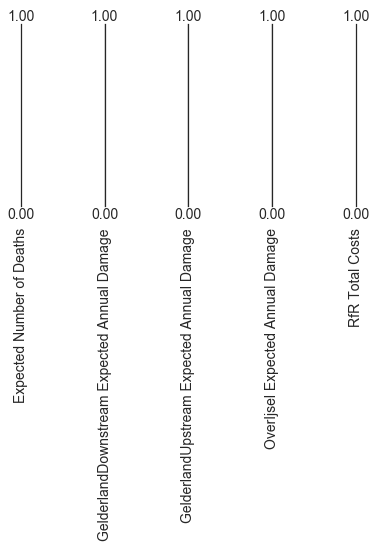

In [33]:
from ema_workbench.analysis import parcoords

data = results.loc[:, [o.name for o in robustness_functions]]
limits = parcoords.get_limits(data)
limits.loc[0, :] = 0
limits.loc[1, :] = 1

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()

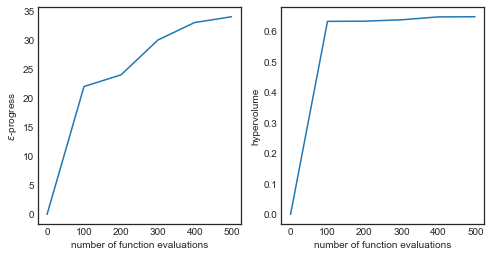

In [35]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence.nfe, convergence.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()

In [ ]:
from ema_workbench import save_results
#save_results(x,'MORO_policies.tar.gz')
res.to_csv('MORO_policies_8obj_filtered.csv')
# save_results(policies_to_evaluate,'MORO_filtered_policies')

### 3.4 Evaluate Policies

In [ ]:
from ema_workbench import Policy

policies = res.drop([o.name for o in robustness_functions], axis=1)
policies_to_evaluate = []

for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy("moro {}".format(i), **policy.to_dict()))

In [ ]:
n_scenarios = 1000
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios,
                                            policies_to_evaluate)

In [ ]:
results.to_csv('MORO_policies_8obj_filtered_evaluated_500.csv')

In [ ]:
import pandas as pd
experiments, outcomes = results

overall_robustness = {}
for policy in np.unique(experiments['policy']):
    policy_robustness = {}

    logical = experiments['policy'] == policy
    
    for outcome, values in outcomes.items():
        values = values[logical]
        policy_robustness[outcome] = robustness_funcs[outcome](values)
    overall_robustness[policy] = policy_robustness
overall_robustness = pd.DataFrame.from_dict(overall_robustness).T
overall_robustness = overall_robustness[overall_robustness["Expected Number of Deaths"]>0.5]
overall_robustness

In [ ]:
data = overall_robustness.loc[:, [o.name for o in robustness_functions]]
limits = parcoords.get_limits(data)
limits.loc[0, :] = 0
limits.loc[1, :] = 1

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()